### Plotting losses

In [16]:
-- load the loss and test loss
--[[
losses = torch.load('/data/twwright/jobs/2016-01-12_22:30:17_001AutoEncoderTest/losses_1.t7')
test_losses = torch.load('/data/twwright/jobs/2016-01-12_22:30:17_001AutoEncoderTest/test_losses_1.t7')

losses = torch.load('/data/twwright/jobs/2016-01-13_09:17:56_004AutoEncoder-BN/losses_3.t7')
test_losses = torch.load('/data/twwright/jobs/2016-01-13_09:17:56_004AutoEncoder-BN/test_losses_3.t7')
--]]

losses = torch.load('jobs/2016-03-06_21:34:53_SegmentationDAGCropOpt2|BCEW500|Skip10|/losses_12.t7')
test_losses = torch.load('jobs/2016-03-06_21:34:53_SegmentationDAGCropOpt2|BCEW500|Skip10|/test_losses_12.t7')

print('Done')

Done	


In [17]:
-- plot losses!
local Plot = require 'itorch.Plot'

-- construct batch training loss data
batch_loss_x = torch.range(1, #losses)
batch_loss_y = torch.Tensor(losses)

-- construct test loss data
local test_loss_x = {}
local test_loss_y = {}
for i, v in pairs(test_losses) do
    test_loss_x[#test_loss_x + 1] = i
end
table.sort(test_loss_x)
for _, v in ipairs(test_loss_x) do
    test_loss_y[#test_loss_y + 1] = test_losses[v]
end
test_loss_x = torch.Tensor(test_loss_x)
test_loss_y = torch.Tensor(test_loss_y)

-- construct mean epoch training loss data
epoch_loss_x = test_loss_x:clone()
epoch_loss_y = test_loss_y:clone() -- just need a tensor of the same size
for i = 1, epoch_loss_y:size(1) do
  -- compute mean of batch losses for this epoch
  local epoch_start = 1
  if i > 1 then epoch_start = test_loss_x[i-1] end
  local epoch_end = test_loss_x[i]
  epoch_loss_y[i] = batch_loss_y[{{epoch_start, epoch_end}}]:mean()
end

local plot = Plot()
plot:line(batch_loss_x, batch_loss_y, 'red', 'Training Loss')
plot:line(test_loss_x, test_loss_y, 'blue', 'Test Loss')
plot:line(epoch_loss_x, epoch_loss_y, 'green', 'Training Loss (Mean)')
plot:title('Losses')
plot:xaxis('x'):yaxis('y')
plot:legend(true)
plot:draw()

# Calculating precision-recall

### Define parameters

In [3]:
require 'nn'
require 'cunn'
require 'jobs.mi_utils'
require 'nngraph'
opt = {
    batch_size=64,
    window_size=3,
    shuffle_datasets=false,
    input_subsample = 2,
    label_subsample = 2,
    prediction_upsample = true,
    force_binary_labels = true,
    --evaluation_subsample = 8,
    crops = 2,
    skip_negative_labels = 25, -- only take every 20th negative example
    pr_thresholds = 15,
    load_batch_size = 1,
    load_labels = true,
    dataset_file = '/data/twwright/lidc_idri_list',
    dataset_split = 0.7,
    dataset_root = '/data/twwright/lidc_out/',
    base_thickness = 2.5,
    max_dataset_size = 1000,
    size = 512
}

if not log then
    log = print
end

### Load a model

In [5]:
if model then 
  model:clearState()
  model = nil
end
collectgarbage()

model = torch.load('jobs/2016-03-02_16:19:21_SegmentationDAGCropOpt|JoinModel|/model_8.t7')
print('Done')

Done	


### Visualise loaded data and outputs

Loading data	


Initialising and setting loader	


  64
   1
   7
 128
 128
[torch.LongStorage of size 5]

Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Batch 1 (64), 64 inputs loaded, 64 labels loaded	


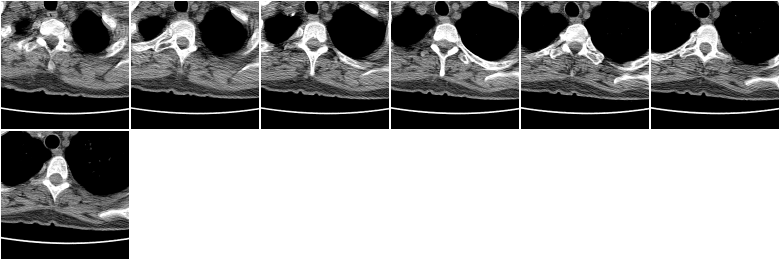

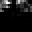

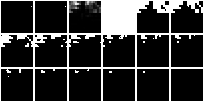

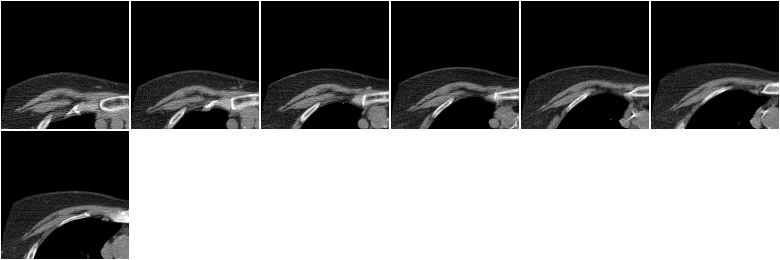

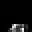

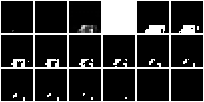

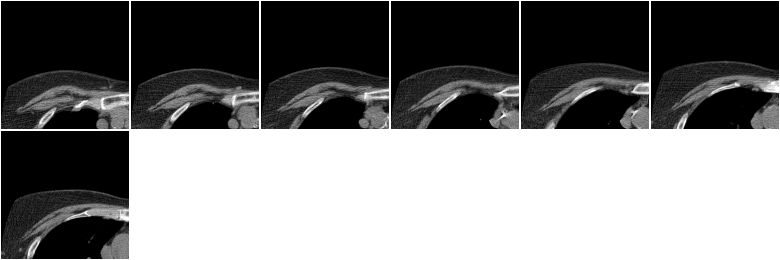

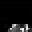

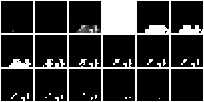

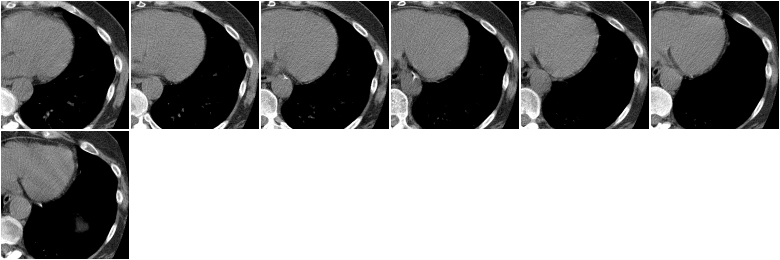

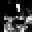

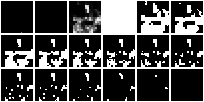

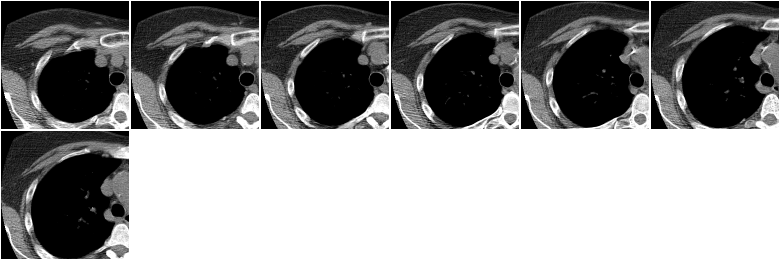

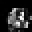

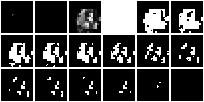

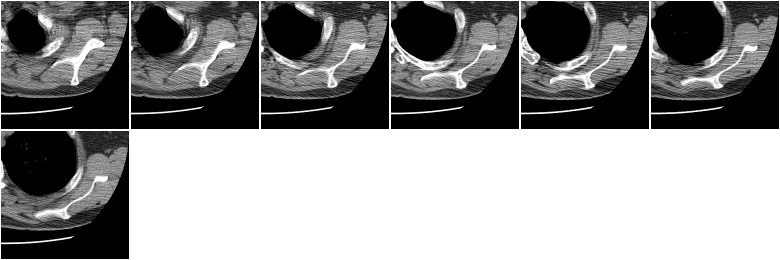

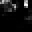

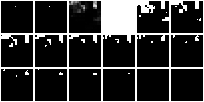

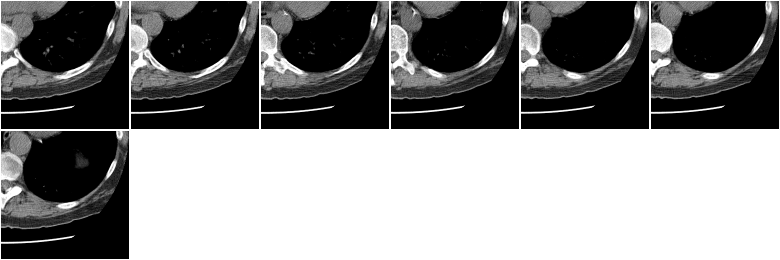

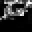

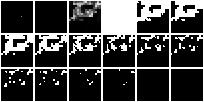

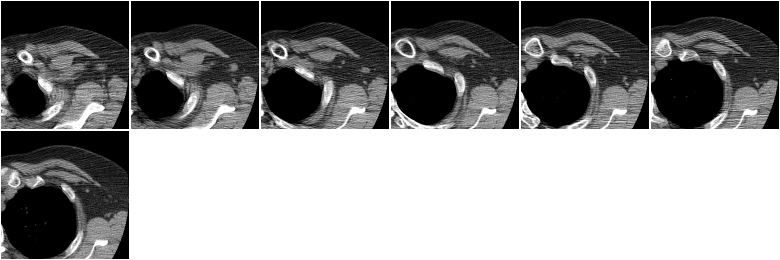

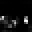

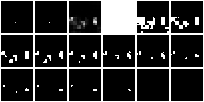

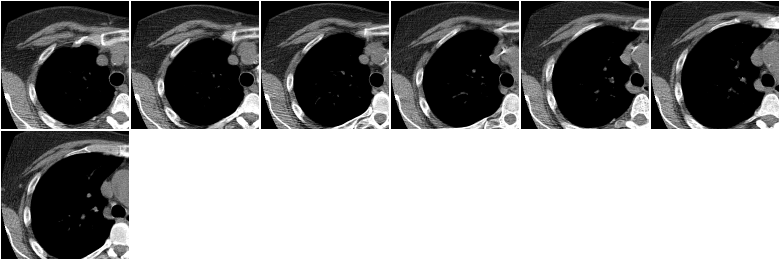

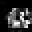

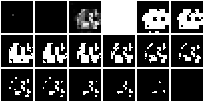

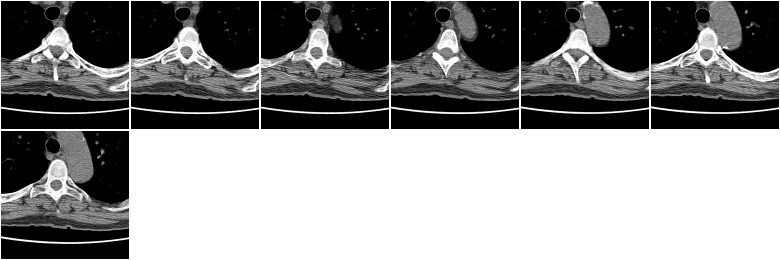

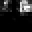

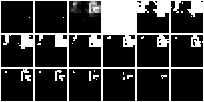

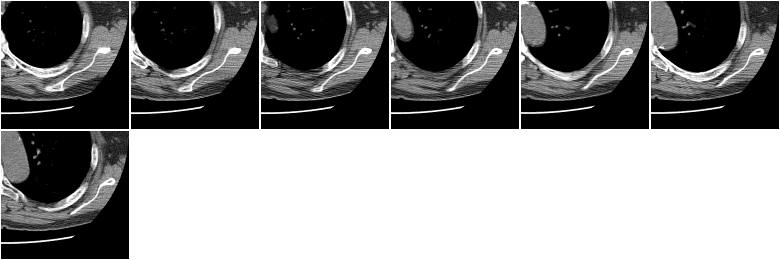

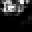

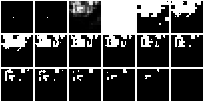

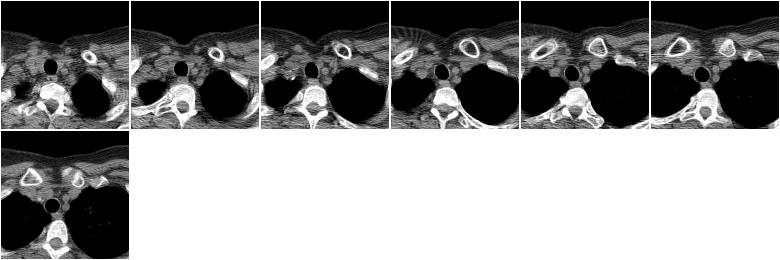

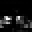

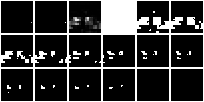

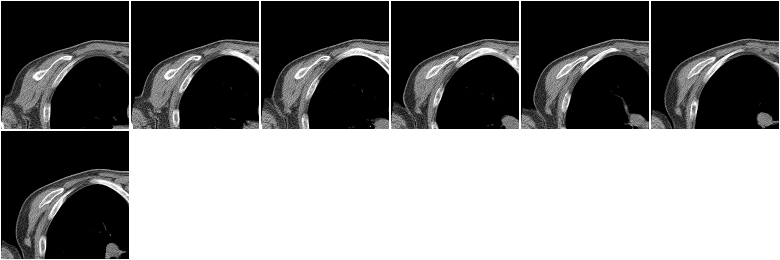

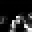

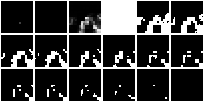

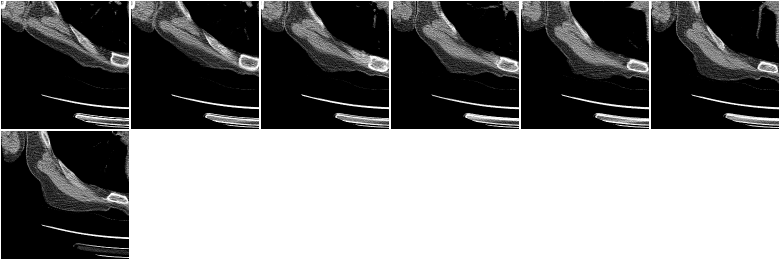

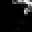

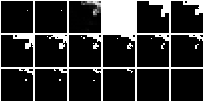

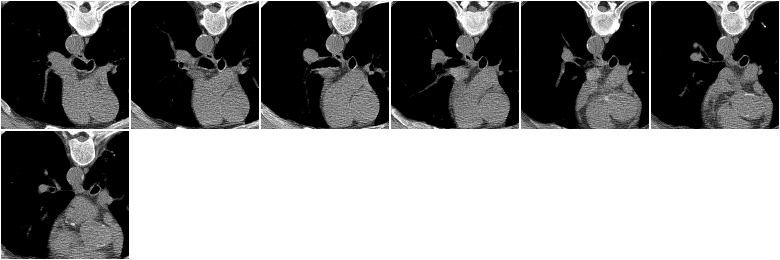

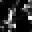

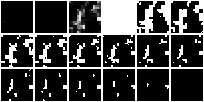

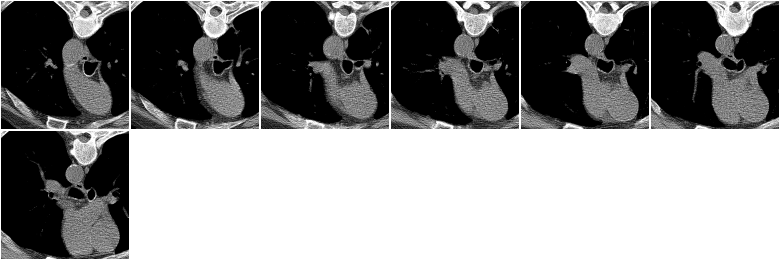

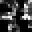

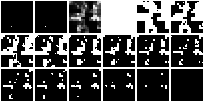

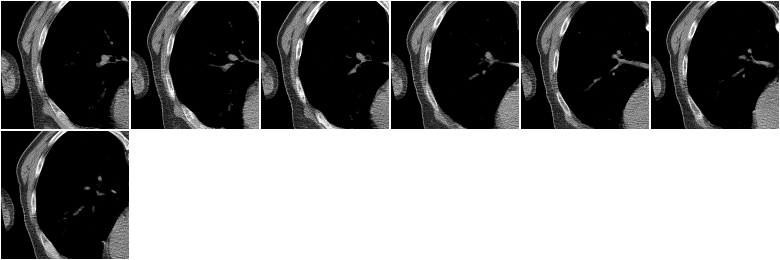

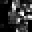

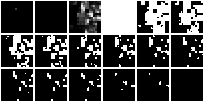

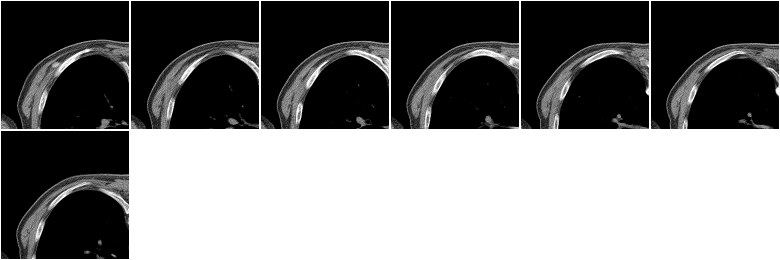

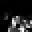

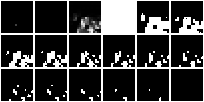

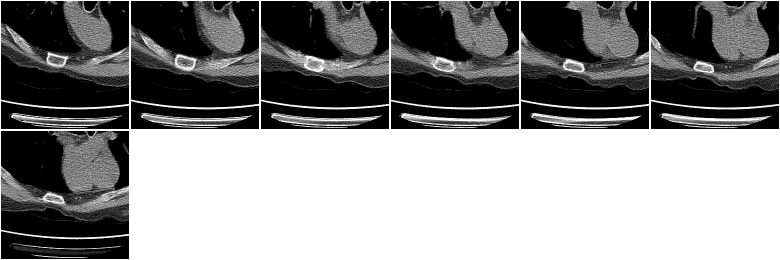

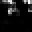

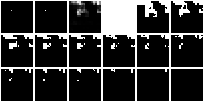

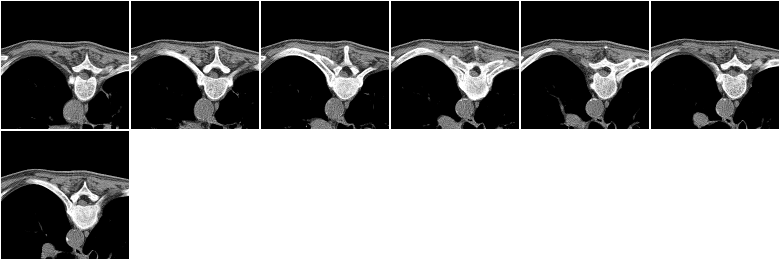

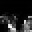

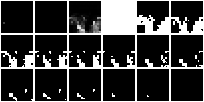

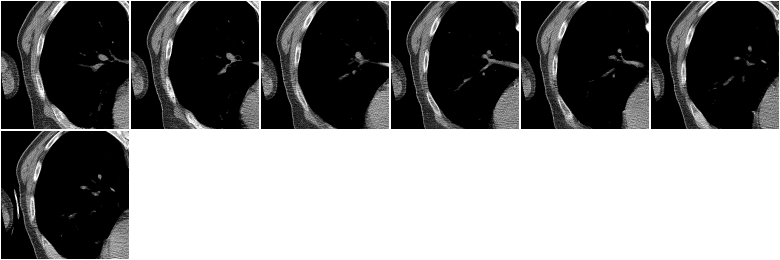

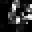

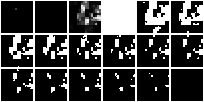

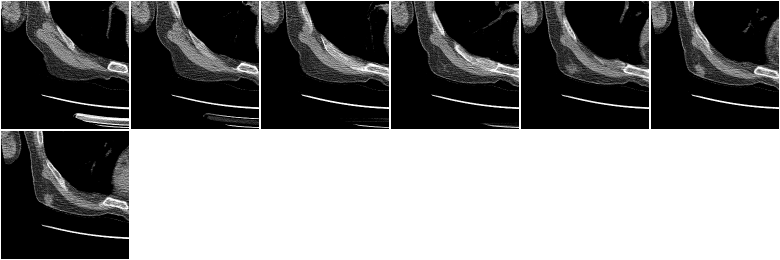

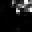

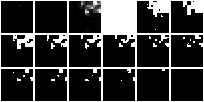

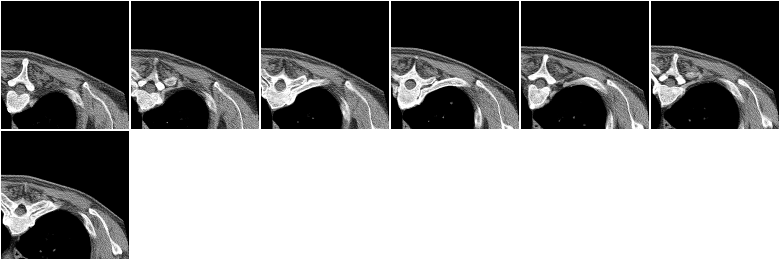

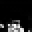

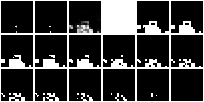

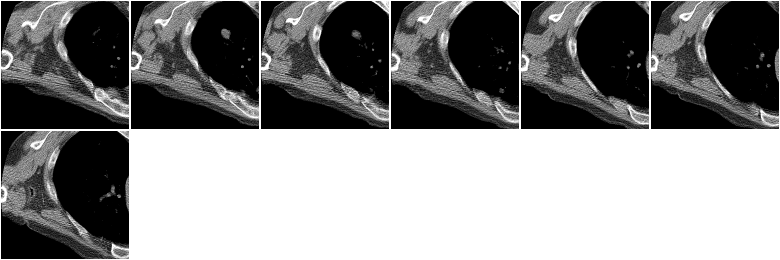

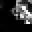

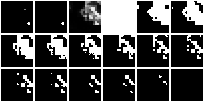

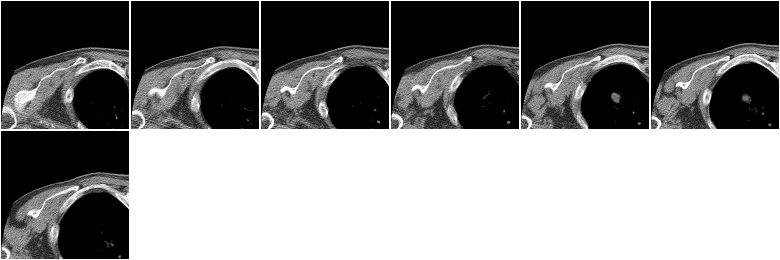

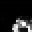

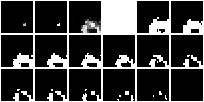

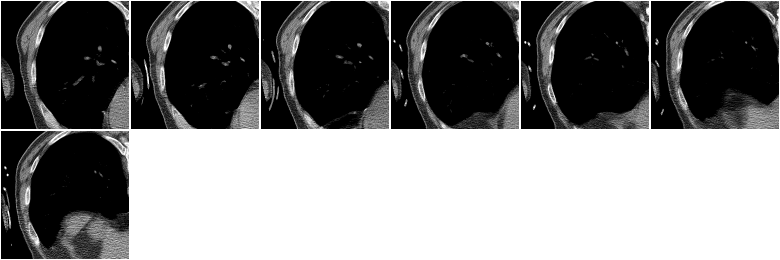

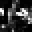

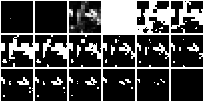

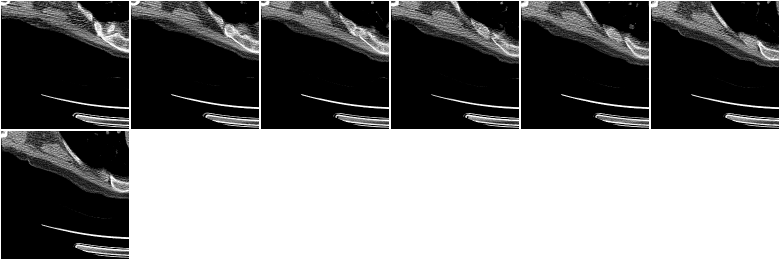

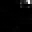

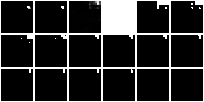

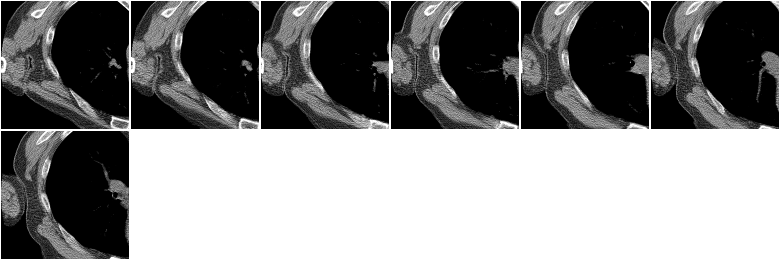

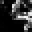

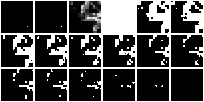

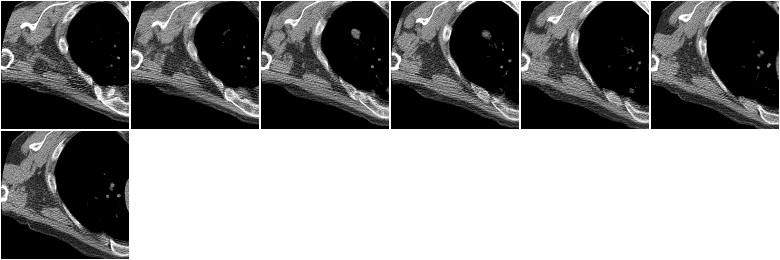

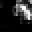

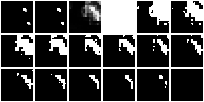

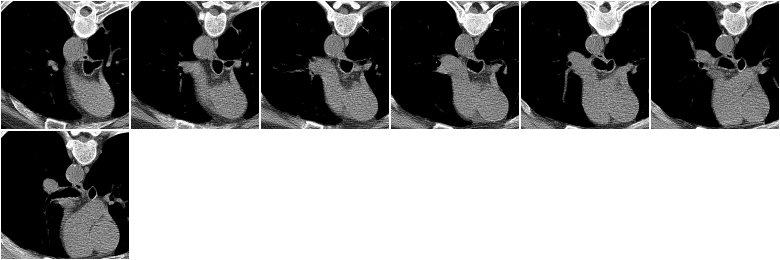

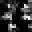

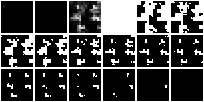

In [7]:

local use_sequential_loader = false
local show_inputs = true
local show_labels = true
local show_output = true
local skip_negatives = true
local count_positives = false

local thresholds = torch.linspace(0, 1, opt.pr_thresholds)

print('Loading data')
dataset = mi_load_dataset(opt, function(e) return opt.base_thickness % e.slice_thickness < 0.0001 end)

print('Initialising and setting loader')
local loader_file = 'jobs.loader_mixed'
if use_sequential_loader then loader_file = 'jobs.loader_sequential' end

local max_pool
if opt.evaluation_subsample then
  max_pool = nn.SpatialMaxPooling(opt.evaluation_subsample, opt.evaluation_subsample):float()
end

local loader = require(loader_file)
loader:init(opt)
loader:set(dataset.test)
if use_sequential_loader then
  loader:next()
end
print(loader.batch_inputs:size())
local loaded = 0
local batches = 0
local count = 30
local positive_count = 0
local total_count = 0
repeat
    -- load batch
    loaded, inputs, labels = loader:load()
    if loaded > 0 then
      batches = batches + 1
      total_count = total_count + loaded
      -- output some details for the batch
      local str = 'Batch ' .. batches .. ' (' .. loaded .. ')'
      if inputs then
          str = str .. ', ' .. inputs:size(1) .. ' inputs loaded'
      else
          str = str .. ', no inputs loaded'
      end
      if labels then
          str = str .. ', ' .. labels:size(1) .. ' labels loaded'
          -- count the positives
          for i = 1, loaded do
            if labels[i]:gt(0.5):sum() > 0 then positive_count = positive_count + 1 end
          end
          if opt.evaluation_subsample then
            labels = max_pool:forward(labels:clone():squeeze():float()):clone()
          end
      else
          str = str .. ', no labels loaded'
      end
      print(str)  
      -- evaluate the batch if required
      local outputs
      if show_output and model then
        outputs = model:forward(inputs)
        if opt.evaluation_subsample then
          outputs = max_pool:forward(outputs:clone():float()):clone()
        end
      end
      -- output stuff for the batch
      for i = 1, loaded do
        if not labels or not skip_negatives or labels[i]:sum() > 0 then
          -- display inputs
          if show_inputs then
            itorch.image(inputs[i]:squeeze())
          end
          local image_outputs = {}
          -- display labels
          if show_labels and labels then
            table.insert(image_outputs, labels[i]:squeeze())
            table.insert(image_outputs, labels[i]:squeeze():gt(0.5))
          end
          -- display output
          if show_output and model then
            itorch.image(outputs[i]:squeeze())
            table.insert(image_outputs, outputs[i]:squeeze())
            for j = 1, thresholds:size(1) do
              table.insert(image_outputs, outputs[i]:squeeze():ge(thresholds[j]))
            end
          end
          if #image_outputs > 0 then
            itorch.image(image_outputs)
          end
          count = count - 1
          if count == 0 then break end
        end
      end
    end
until loaded < opt.batch_size or count == 0

### Evaluate

In [6]:
-- Prepare testing dataset and loader
print('Loading data')
dataset = mi_load_dataset(opt, function(e) return opt.base_thickness % e.slice_thickness < 0.0001 end)

print('Initialising and setting loader')
local loader = dofile 'jobs/loader_sequential.lua'
loader:init(opt)
loader:set(dataset.test)

-- Prepare evaluation
local num_thresholds = opt.pr_thresholds
thresholds = torch.linspace(0, 1, num_thresholds)
print('Thresholds')
print(thresholds)
-- 4: (tp, fp, tn, fn), 5: precision, 6: recall, 7: fpr, 8: acc 
results = torch.FloatTensor(#loader.dataset, thresholds:size(1), 8):zero() 
evaluated_count = 0

-- create an output tensor to compile the crops into for each slice
local total_output = torch.FloatTensor(opt.size / opt.label_subsample, opt.size / opt.label_subsample):cuda()
total_output:fill(0)
-- create a CUDA label tensor to copy the slice label into for evaluation
--local cuda_label = torch.FloatTensor(opt.size / opt.label_subsample, opt.size / opt.label_subsample):cuda()

local output_slices = false

if opt.evaluation_subsample then
  local s_in = opt.size / opt.label_subsample
  local s_out = s_in / opt.evaluation_subsample
  local pool_in = nn.View(1, s_in, s_in)()
  local pool_out = nn.View(s_out, s_out)(nn.SpatialMaxPooling(opt.evaluation_subsample, opt.evaluation_subsample)(pool_in))
  max_pool = nn.gModule({pool_in}, {pool_out}):float()
end

-- Evaluate testing dataset
local time = os.clock()
for i = 1, #loader.dataset do
  -- load the next example, but check if it has any nodules before we process it
  local loaded_windows = loader:next(i)
  if loaded_windows > 0 and loader.loaded.label:gt(0.5):sum() > 0 then
    -- evaluate the example
    local loaded = 0
    local batch = 0
    local crop = 0
    local depth = 1 -- start at the first slice
    repeat
      -- load a batch sequentially
      loaded, inputs, labels = loader:load()
      if loaded > 0 then
        -- evaluate training batch
        local outputs = model:forward(inputs)

        batch = batch + 1
        
        -- process batch to apply each crop to correct slice
        for j = 1, loaded do
          -- check if we have moved to the next slice (depth is 1-based, crop is 0-based)
          if crop >= (2 * opt.crops - 1) * (2 * opt.crops - 1) then
            -- evaluate the completed slice
            --cuda_label:copy(loader.loaded.label[depth])
            local y = loader.loaded.label[depth]:gt(0.5):float()
            if opt.evaluation_subsample then
              y = max_pool:forward(y):clone()
            end
            local images = {y}
            for k = 1, thresholds:size(1) do
                local y_hat = total_output:ge(thresholds[k]):float()
                if opt.evaluation_subsample then
                  y_hat = max_pool:forward(y_hat):clone()
                end
                images[#images + 1] = y_hat
                y_hat:mul(2):add(y)
                results[i][k][1] = results[i][k][1] + y_hat:eq(3):sum() -- true positive: 1x2 + 1
                results[i][k][2] = results[i][k][2] + y_hat:eq(2):sum() -- false positive: 1x2 + 0
                results[i][k][3] = results[i][k][3] + y_hat:eq(0):sum() -- true negative: 0x2 + 0
                results[i][k][4] = results[i][k][4] + y_hat:eq(1):sum() -- false negative: 0x2 + 1
            end
            if y:sum() > 0 and output_slices then
              itorch.image(images)
            end
            -- move to the next slice
            depth = depth + 1
            crop = 0
            total_output:fill(0)
          end
          -- calculate crop dimensions
          local crop_size = (opt.size / opt.label_subsample) / opt.crops
          local crop_x = (crop % (2 * opt.crops - 1)) * (crop_size / 2) -- stride of half the crop_size
          local crop_y = math.floor(crop / (2 * opt.crops - 1)) * (crop_size / 2) -- stride of half the crop_size
          -- max the crop into the slice
          local total_output_cropped = total_output[{{crop_y + 1, crop_y + crop_size}, {crop_x + 1, crop_x + crop_size}}]
          total_output_cropped:cmax(outputs[j])
          --itorch.image(outputs[j])
          --itorch.image(total_output)
          -- increment crop for next time
          crop = crop + 1
        end
      end
    until loaded == 0
    
    -- calculate precision and recall if we processed any batches
    for j = 1, thresholds:size(1) do
        local tp = results[i][j][1]
        local fp = results[i][j][2]
        local tn = results[i][j][3]
        local fn = results[i][j][4]
        if fp == 0 then
          results[i][j][5] = 0
        else
          results[i][j][5] = tp / (tp + fp) -- precision = tp / (tp + fp)
        end
        results[i][j][6] = tp / (tp + fn) -- recall = tp / (tp + fn)
        results[i][j][7] = fp / (fp + tn) -- fpr
        results[i][j][8] = (tp + tn) / (tp + fp + tn + fn) -- accuracy
    end
    
    -- increment the evaluation count
    evaluated_count = evaluated_count + 1
    
    print('Evaluated: ' .. evaluated_count .. ' / ' .. i)
  end
end
print(string.format('Done in %.2fs', os.clock() - time))

Loading data	


Initialising and setting loader	


Thresholds	


 0.0000
 0.0714
 0.1429
 0.2143
 0.2857
 0.3571
 0.4286
 0.5000
 0.5714
 0.6429
 0.7143
 0.7857
 0.8571
 0.9286
 1.0000
[torch.DoubleTensor of size 15]

Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 1 / 1	
Loading 1 inputs...	


Loaded 675 new windows (1 inputs)	


Loading 1 inputs...	

Loaded 531 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 504 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 2 / 6	
Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 3 / 7	
Loading 1 inputs...	


Loaded 504 new windows (1 inputs)	


Evaluated: 4 / 8	
Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 522 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Evaluated: 5 / 11	
Loading 1 inputs...	


Loaded 666 new windows (1 inputs)	


Evaluated: 6 / 12	
Loading 1 inputs...	


Loaded 621 new windows (1 inputs)	


Evaluated: 7 / 13	
Loading 1 inputs...	


Loaded 603 new windows (1 inputs)	


Evaluated: 8 / 14	
Loading 1 inputs...	


Loaded 531 new windows (1 inputs)	


Evaluated: 9 / 15	
Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Evaluated: 10 / 16	
Loading 1 inputs...	


Loaded 477 new windows (1 inputs)	


Evaluated: 11 / 17	
Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Evaluated: 12 / 21	


Loading 1 inputs...	


Loaded 450 new windows (1 inputs)	


Evaluated: 13 / 22	
Loading 1 inputs...	


Loaded 468 new windows (1 inputs)	


Evaluated: 14 / 23	
Loading 1 inputs...	

Loaded 540 new windows (1 inputs)	


Evaluated: 15 / 24	
Loading 1 inputs...	


Loaded 522 new windows (1 inputs)	


Evaluated: 16 / 25	
Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 17 / 26	
Loading 1 inputs...	


Loaded 603 new windows (1 inputs)	


Evaluated: 18 / 27	


Loading 1 inputs...	


Loaded 504 new windows (1 inputs)	


Evaluated: 19 / 28	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Evaluated: 20 / 29	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	

Evaluated: 21 / 30	
Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Evaluated: 22 / 31	
Loading 1 inputs...	


Loaded 531 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 621 new windows (1 inputs)	


Evaluated: 23 / 33	
Loading 1 inputs...	


Loaded 531 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 24 / 35	
Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 25 / 37	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 26 / 39	
Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 27 / 40	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 28 / 42	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Evaluated: 29 / 43	
Loading 1 inputs...	


Loaded 531 new windows (1 inputs)	


Evaluated: 30 / 44	
Loading 1 inputs...	


Loaded 468 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 31 / 46	
Loading 1 inputs...	


Loaded 630 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Evaluated: 32 / 48	
Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 33 / 49	
Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Evaluated: 34 / 50	
Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Evaluated: 35 / 51	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 36 / 54	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Evaluated: 37 / 57	
Loading 1 inputs...	


Loaded 441 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 38 / 59	
Loading 1 inputs...	


Loaded 657 new windows (1 inputs)	


Evaluated: 39 / 60	
Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 40 / 61	
Loading 1 inputs...	


Loaded 468 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 666 new windows (1 inputs)	


Evaluated: 41 / 63	
Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Evaluated: 42 / 64	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 414 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 414 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 504 new windows (1 inputs)	


Evaluated: 43 / 68	
Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Evaluated: 44 / 69	
Loading 1 inputs...	


Loaded 513 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 495 new windows (1 inputs)	


Evaluated: 45 / 71	
Loading 1 inputs...	


Loaded 648 new windows (1 inputs)	


Evaluated: 46 / 72	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 47 / 73	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	

Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	

Evaluated: 48 / 75	
Loading 1 inputs...	


Loaded 621 new windows (1 inputs)	


Evaluated: 49 / 76	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Evaluated: 50 / 77	
Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 51 / 78	
Loading 1 inputs...	

Loaded 576 new windows (1 inputs)	


Evaluated: 52 / 79	
Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 53 / 80	
Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Evaluated: 54 / 81	
Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Evaluated: 55 / 82	
Loading 1 inputs...	

Loaded 540 new windows (1 inputs)	


Evaluated: 56 / 83	
Loading 1 inputs...	


Loaded 513 new windows (1 inputs)	


Evaluated: 57 / 84	
Loading 1 inputs...	


Loaded 621 new windows (1 inputs)	


Evaluated: 58 / 85	
Loading 1 inputs...	


Loaded 396 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 423 new windows (1 inputs)	


Evaluated: 59 / 87	
Loading 1 inputs...	


Loaded 531 new windows (1 inputs)	


Evaluated: 60 / 88	
Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 61 / 89	


Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Evaluated: 62 / 90	
Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Evaluated: 63 / 91	
Loading 1 inputs...	


Loaded 522 new windows (1 inputs)	


Evaluated: 64 / 92	
Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 65 / 93	
Loading 1 inputs...	

Loaded 549 new windows (1 inputs)	


Evaluated: 66 / 94	
Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 67 / 96	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Evaluated: 68 / 98	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 69 / 99	
Loading 1 inputs...	


Loaded 477 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 70 / 101	
Loading 1 inputs...	


Loaded 621 new windows (1 inputs)	


Evaluated: 71 / 102	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 72 / 103	
Loading 1 inputs...	


Loaded 621 new windows (1 inputs)	


Evaluated: 73 / 104	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 477 new windows (1 inputs)	


Evaluated: 74 / 106	
Loading 1 inputs...	


Loaded 513 new windows (1 inputs)	


Evaluated: 75 / 107	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 76 / 108	
Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 77 / 109	
Loading 1 inputs...	


Loaded 486 new windows (1 inputs)	


Evaluated: 78 / 110	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 432 new windows (1 inputs)	


Evaluated: 79 / 112	
Loading 1 inputs...	


Loaded 468 new windows (1 inputs)	


Evaluated: 80 / 113	


Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Evaluated: 81 / 114	
Loading 1 inputs...	

Loaded 630 new windows (1 inputs)	


Evaluated: 82 / 115	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 83 / 116	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 84 / 117	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Evaluated: 85 / 118	
Loading 1 inputs...	


Loaded 522 new windows (1 inputs)	


Evaluated: 86 / 119	
Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Evaluated: 87 / 120	
Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	

Evaluated: 88 / 121	
Loading 1 inputs...	


Loaded 639 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 89 / 124	
Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 90 / 125	
Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Evaluated: 91 / 126	
Loading 1 inputs...	


Loaded 603 new windows (1 inputs)	

Evaluated: 92 / 127	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	

Evaluated: 93 / 128	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 513 new windows (1 inputs)	


Evaluated: 94 / 131	
Loading 1 inputs...	


Loaded 621 new windows (1 inputs)	


Evaluated: 95 / 132	
Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 96 / 133	
Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 97 / 134	
Loading 1 inputs...	


Loaded 522 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 459 new windows (1 inputs)	


Evaluated: 98 / 136	
Loading 1 inputs...	


Loaded 495 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 99 / 138	
Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Evaluated: 100 / 140	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 101 / 141	
Loading 1 inputs...	


Loaded 603 new windows (1 inputs)	


Evaluated: 102 / 142	
Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 103 / 144	
Loading 1 inputs...	


Loaded 603 new windows (1 inputs)	


Evaluated: 104 / 145	
Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 105 / 146	
Loading 1 inputs...	


Loaded 630 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Evaluated: 106 / 148	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 468 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 495 new windows (1 inputs)	


Evaluated: 107 / 151	
Loading 1 inputs...	


Loaded 513 new windows (1 inputs)	


Evaluated: 108 / 152	
Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 109 / 153	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 110 / 155	
Loading 1 inputs...	


Loaded 513 new windows (1 inputs)	


Evaluated: 111 / 156	
Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Evaluated: 112 / 157	
Loading 1 inputs...	


Loaded 522 new windows (1 inputs)	


Evaluated: 113 / 158	
Loading 1 inputs...	


Loaded 531 new windows (1 inputs)	


Evaluated: 114 / 159	
Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Evaluated: 115 / 160	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 116 / 162	
Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 414 new windows (1 inputs)	


Evaluated: 117 / 165	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 522 new windows (1 inputs)	


Evaluated: 118 / 167	
Loading 1 inputs...	


Loaded 513 new windows (1 inputs)	


Evaluated: 119 / 168	
Loading 1 inputs...	


Loaded 504 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 549 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 120 / 171	
Loading 1 inputs...	

Loaded 558 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Evaluated: 121 / 173	
Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 122 / 174	
Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 123 / 177	


Loading 1 inputs...	


Loaded 513 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 504 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Evaluated: 124 / 181	


Loading 1 inputs...	


Loaded 576 new windows (1 inputs)	


Evaluated: 125 / 182	


Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 126 / 183	
Loading 1 inputs...	


Loaded 540 new windows (1 inputs)	


Evaluated: 127 / 184	
Loading 1 inputs...	


Loaded 495 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 585 new windows (1 inputs)	


Evaluated: 128 / 186	
Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 612 new windows (1 inputs)	


Evaluated: 129 / 188	
Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Evaluated: 130 / 190	
Loading 1 inputs...	


Loaded 594 new windows (1 inputs)	


Evaluated: 131 / 191	
Loading 1 inputs...	


Loaded 558 new windows (1 inputs)	


Loading 1 inputs...	


Loaded 567 new windows (1 inputs)	


Evaluated: 132 / 193	
Done in 1274.72s	


### Plot PR curves

In [15]:

local evaluation_file = 'jobs/2016-03-06_21:34:53_SegmentationDAGCropOpt2|BCEW500|Skip10|/evaluation_12.t7'

local res
if evaluation_file then
  print('Loading evaluation from "' .. evaluation_file .. '"')
  res = torch.load(evaluation_file)
  
  -- create thresholds
  thresholds = torch.linspace(0, 1, res:size(1))
else
  local mean_results = results:sum(1):squeeze() / evaluated_count -- take mean along the last axis

  -- adjust results to avoid NaNs
  local eps = 0.000001
  mean_results[mean_results:lt(eps)] = eps

  -- create a new tensor with room for F-score
  local res = torch.FloatTensor(mean_results:size(1), mean_results:size(2) + 1)
  res[{{}, {1, mean_results:size(2)}}]:copy(mean_results)

  local fscore = precision:clone():cmul(recall) -- fscore = 2 * ((precision*recall)/(precision+recall))
  local temp_denom = torch.add(precision, recall)
  fscore:cdiv(temp_denom):mul(2)
  res[{{}, 9}]:copy(fscore)
end

-- retrieve metrics from results
local precision = res[{{}, 5}]
local recall = res[{{}, 6}]
local fpr = res[{{}, 7}]
local acc = res[{{}, 8}]
local fscore = res[{{}, 9}]

-- display results
print(res)

local Plot = require 'itorch.Plot'

-- PR curve
plot = Plot()
plot:line(thresholds, precision, 'red', 'Precision (tp / tp+fp)')
plot:line(thresholds, recall, 'blue', 'Recall (tp / tp+fn)')
plot:line(thresholds, fscore, 'orange', 'Fscore (2 * p*r / p+r)')
plot:title('Mean Precision/Recall')
plot:xaxis('threshold')
plot:legend(true)
plot:draw()

--[[
-- ROC curve true positive rate (recall) vs. false positive rate
plot = Plot()

plot:line(fpr, recall, 'red', 'ROC')
plot:title('ROC Curve')
plot:yaxis('TPR (tp / tp + fn)')
plot:xaxis('FPR (fp / fp + tn)')
plot:legend(true)
plot:draw()
--]]

Loading evaluation from "jobs/2016-03-06_21:34:53_SegmentationDAGCropOpt2|BCEW500|Skip10|/evaluation_12.t7"	
Columns 1 to 6
 1.2476e+02  4.0120e+06  1.0000e-06  1.0000e-06  3.1411e-05  1.0000e+00
 9.6758e+01  1.2536e+05  3.8866e+06  2.8000e+01  7.8447e-04  5.1975e-01
 9.0492e+01  6.5031e+04  3.9469e+06  3.4265e+01  1.4073e-03  4.3385e-01
 8.6447e+01  4.1559e+04  3.9704e+06  3.8311e+01  2.0862e-03  4.1720e-01
 8.2424e+01  2.8565e+04  3.9834e+06  4.2333e+01  2.8560e-03  3.8799e-01
 7.8902e+01  2.0174e+04  3.9918e+06  4.5856e+01  3.8014e-03  3.7089e-01
 7.5598e+01  1.4239e+04  3.9977e+06  4.9159e+01  5.0510e-03  3.5069e-01
 7.2659e+01  9.7790e+03  4.0022e+06  5.2098e+01  6.8245e-03  3.3474e-01
 6.8697e+01  6.3623e+03  4.0056e+06  5.6061e+01  9.5992e-03  3.1387e-01
 6.3348e+01  3.6779e+03  4.0083e+06  6.1409e+01  1.4263e-02  2.8037e-01
 5.4326e+01  1.5128e+03  4.0105e+06  7.0432e+01  2.6284e-02  2.4656e-01
 1.0000e-06  1.0000e-06  4.0120e+06  1.2476e+02  1.0000e-06  1.0000e-06

Columns 7 t

In [1]:
require 'cutorch'
print(cutorch.getDeviceCount())
print(cutorch.getDevice())
--test = nil
collectgarbage()

cuda runtime error (38) : no CUDA-capable device is detected at /root/torch/extra/cutorch/lib/THC/THCGeneral.c:16
stack traceback:
	[C]: at 0x7ff8cf4fe500
	[C]: in function 'require'
	/root/torch/install/share/lua/5.1/cutorch/init.lua:2: in main chunk
	[C]: in function 'require'
	[string "require 'cutorch'..."]:1: in main chunk
	[C]: in function 'xpcall'
	/root/torch/install/share/lua/5.1/itorch/main.lua:209: in function </root/torch/install/share/lua/5.1/itorch/main.lua:173>
	/root/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/root/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/root/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/root/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/root/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 

In [ ]:
os.execute("ll")

In [ ]:
print(lfs.currentdir())
print(lfs.sep)

### Count positive windows in dataset

In [ ]:
require 'nn'
require 'cunn'
require 'jobs.mi_utils'
require 'nngraph'
opt = {
    batch_size=256,
    window_size=2,
    shuffle_datasets=false,
    subsample = 2,
    crops = 1,
    pr_thresholds = 6,
    load_batch_size = 50,
    load_labels = true,
    dataset_file = '/data/twwright/lidc_idri_list',
    dataset_split = 1.0,
    dataset_root = '/data/twwright/lidc_out/',
    base_thickness = 2.5,
    max_dataset_size = 2000,
    size = 512
}

if not log then
    log = print
end

local use_sequential_loader = false
local count_positives = true

print('Loading data')
dataset = mi_load_dataset(opt, function(e) return opt.base_thickness % e.slice_thickness < 0.0001 end)

print('Initialising and setting loader')
local loader_file = 'jobs.loader_mixed'
if use_sequential_loader then loader_file = 'jobs.loader_sequential' end

local loader = require(loader_file)
loader:init(opt)
loader:set(dataset.train)

print(loader.batch_inputs:size())
local loaded = 0
local batches = 0
local count = 1
local positive_count = 0
local total_count = 0
local print_every = 50
repeat
  -- load batch
  loaded, inputs, labels = loader:load()
  if loaded > 0 then
    batches = batches + 1
    total_count = total_count + loaded
    -- count the positives
    for i = 1, loaded do
      if labels[i]:gt(0.5):sum() > 0 then positive_count = positive_count + 1 end
    end
    
    if batches % print_every == 0 then
      print(string.format('Batches %d (%d / %d positive)', batches, positive_count, total_count))
    end
  end
until loaded < opt.batch_size or count == 0
print('Done!')
print(string.format('Batches %d (%d / %d positive)', batches, positive_count, total_count))

### Determine scans that have positive pixels

In [ ]:
require 'jobs.mi_utils'
require 'nngraph'
opt = {
    batch_size=256,
    window_size=2,
    shuffle_datasets=false,
    subsample = 2,
    crops = 1,
    pr_thresholds = 6,
    load_batch_size = 50,
    load_labels = true,
    dataset_file = '/data/twwright/lidc_idri_list',
    dataset_split = 1.0,
    dataset_root = '/data/twwright/lidc_out/',
    base_thickness = 2.5,
    max_dataset_size = 2000,
    size = 512
}

if not log then
    log = print
end

print('Loading data')
dataset = mi_load_dataset(opt, function(e) return opt.base_thickness % e.slice_thickness < 0.0001 end)

print('Initialising and setting loader')
local loader_file = 'jobs.loader_sequential'

local loader = require(loader_file)
loader:init(opt)
loader:set(dataset.train)
local positive_images = 0
local print_every = 25
for i = 1, #dataset.train do
  -- evaluate the image
  loader:next(i)  
  local loaded = 0
  local positive_count = 0
  repeat
    -- load batch
    loaded, inputs, labels = loader:load()
    if loaded > 0 and labels:gt(0.5):sum() > 0 then
      positive_count = positive_count + 1
    end
  until loaded < opt.batch_size
  
  -- if any positive stuff found, image is positive
  if positive_count > 0 then
    positive_images = positive_images + 1
  end
  
  if i % print_every == 0 then
    print(string.format('Image %d (%d / %d positive)', i, positive_images, i))
  end
end
print('Done!')
print(string.format('Image %d (%d / %d positive)', #dataset.train, positive_images, #dataset.train))